In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
from reservoirpy import nodes, datasets
import hierarchical_genome_mutations_operations as hgmo
import evolution_step_functions as esf
import genome_analysis as ga
import genome_transcription as gt
import helper_functions as hf
import hierarchical_genomes as hg
import random
import copy
# Import any other necessary modules or functions you have defined in your .py files

import reservoirpy as rpy
rpy.verbosity(0)
import networkx as nx
from sklearn.metrics import mean_squared_error, mean_absolute_error


## Variables & Hyperparameters

In [120]:
n_timesteps = 2000
population_size = 50
n_generations = 20
genome_length = 100
elitism_size = 5  # Number of elites to carry over
mutation_probability = 0.05
mutation_rate = 0.1
improvement_threshold = 0.01  # Threshold for adjusting mutation rate
best_fitness = 0  # Initialize with the fitness of the best genome from previous generations
crossover_probability = 0.7  # Probability of crossover
crossover_rate = 0.5
random_restart_interval = 5  # Perform a random restart every 5 generations

# Dataset Initialization
X = datasets.mackey_glass(n_timesteps=n_timesteps, sample_len=2000)
Y = np.roll(X, -1)

# Split the dataset
train_end = int(len(X) * 0.7)
X_train, Y_train = X[:train_end], Y[:train_end]
X_test, Y_test = X[train_end:], Y[train_end:]

elite_count = int(0.05 * population_size)  # 5% of the population will be elite
selected_count = 10  # The top 10 genomes to be selected

increase_factor = 1.05  # Adjust the factor by which the mutation rate is increased.
decrease_factor = 0.95  # Adjust the factor by which the mutation rate is decreased.
stagnation_threshold = 5  # Number of generations without improvement to consider it as stagnation.
best_overall_fitness = float('inf')  # Initialize with infinity or the worst possible fitness score.
stagnation_counter = 0  # To keep track of the number of generations without improvement.

diversity_threshold = 0.1  # Minimum diversity threshold
novelty_threshold = 0.1    # Novelty threshold for fitness function
diversity_penalty_weight = 0.01  # Weight for diversity penalty in fitness calculation




## Mutate Genome

In [109]:

def copy_mutation(genome):
    """Duplicates a random part of the genome."""
    print(f"Mutation : Copy")
    # Example: randomly select a segment to copy
    segment_start = np.random.randint(0, len(genome))
    segment_end = np.random.randint(segment_start, len(genome))
    segment = genome[segment_start:segment_end]
    # Insert the copied segment into a random position
    insert_position = np.random.randint(0, len(genome))
    return genome[:insert_position] + segment + genome[insert_position:]

def shuffle_mutation(genome):
    """Randomly shuffles a segment of the genome."""
    print(f"Mutation : Shuffle")
    segment_start = np.random.randint(0, len(genome))
    segment_end = np.random.randint(segment_start, len(genome))
    segment = genome[segment_start:segment_end]
    np.random.shuffle(segment)
    return genome[:segment_start] + segment + genome[segment_end:]

def add_mutation(genome):
    """Adds a new random element to the genome."""
    print(f"Mutation : Add")
    new_element = np.random.rand()  # Assuming the genome consists of numeric values
    insert_position = np.random.randint(0, len(genome))
    return genome[:insert_position] + [new_element] + genome[insert_position:]


def delete_mutation(genome):
    """Deletes a random element from the genome."""
    print(f"Mutation : Delete")
    if len(genome) > 1:  # Ensure there's something to delete
        delete_position = np.random.randint(0, len(genome))
        return genome[:delete_position] + genome[delete_position+1:]
    return genome


# This is an example mutation function, adjust according to your implementation
def mutate_genome_old(genome):
    # # Apply mutations: copy, shuffle, add, delete
    # # Example of applying a copy mutation
    # genome = copy_mutation(genome)  
    # # Example of applying a shuffle mutation
    # genome = shuffle_mutation(genome) 
    # # Example of applying an add mutation
    # genome = add_mutation(genome)
    # # Example of applying a delete mutation
    # genome = delete_mutation(genome)
    # return genome
    
    # Choose a mutation type randomly for diversity
    #if random.random() < mutation_rate:
    mutation_type = random.choice([copy_mutation, shuffle_mutation, add_mutation, delete_mutation])
    mutated_genome = mutation_type(copy.deepcopy(genome))  # Deep copy for mutation
    ###print(f"Applied {mutation_type.__name__}")  # Logging for verification
    return mutated_genome

def inversion_mutation(genome):
    """
    Invert a random segment of the genome.
    """
    print(f"Mutation : Inversion")
    start_index = np.random.randint(0, len(genome))
    end_index = np.random.randint(start_index, len(genome))
    genome_to_invert = genome[start_index:end_index]
    inverted_segment = genome_to_invert[::-1]  # This reverses the segment
    return genome[:start_index] + inverted_segment + genome[end_index:]

def translocation_mutation(genome):
    """
    Move a segment of the genome to another location.
    """
    print(f"Mutation : Translocation")
    segment_start = np.random.randint(0, len(genome))
    segment_end = np.random.randint(segment_start, len(genome))
    segment = genome[segment_start:segment_end]
    genome_without_segment = genome[:segment_start] + genome[segment_end:]
    insert_position = np.random.randint(0, len(genome_without_segment))
    return genome_without_segment[:insert_position] + segment + genome_without_segment[insert_position:]


def mutate_genome(genome):
    if random.random() < mutation_probability:
        mutation_type = random.choice([copy_mutation, shuffle_mutation, add_mutation, delete_mutation, inversion_mutation, translocation_mutation])
        genome = mutation_type(copy.deepcopy(genome))
    return genome

def adjust_mutation_rate(fitness_scores, best_fitness, current_rate, improvement_threshold):
    """
    Increase mutation rate if there's no improvement over generations.
    Decrease mutation rate if a new best fitness is found.
    """
    if max(fitness_scores) > best_fitness + improvement_threshold:
        # Fitness has improved significantly
        return max(0.1, current_rate * 0.9)  # Decrease mutation rate, not going below 0.1
    else:
        # No significant improvement
        return min(1.0, current_rate * 1.1)  # Increase mutation rate, not going above 1.0


def tournament_selection(population, fitness_scores, tournament_size=3):
    selected_genomes = []
    for _ in range(len(population)):
        competitors = random.sample(list(zip(population, fitness_scores)), tournament_size)
        winner = max(competitors, key=lambda x: x[1])
        selected_genomes.append(winner[0])
    return selected_genomes

def elitism(population, fitness_scores, elite_size):
    sorted_population = sorted(zip(population, fitness_scores), key=lambda x: x[1], reverse=True)
    elites = [genome for genome, _ in sorted_population[:elite_size]]
    return elites


def uniform_crossover(parent1, parent2):
    child = []
    for gene1, gene2 in zip(parent1, parent2):
        child.append(gene1 if random.random() > 0.5 else gene2)
    return child

def calculate_genetic_diversity(population):
    """
    Calculate the genetic diversity of the population based on the genome weights.
    """
    # First, ensure all genomes are lists of tuples
    assert all(isinstance(genome, list) and all(isinstance(gene, tuple) for gene in genome) for genome in population), \
        "All genomes should be lists of tuples."

    # Flatten each genome to get a list of weights
    all_weights = np.concatenate([np.array([gene[2] for gene in genome if isinstance(gene, tuple)]) for genome in population])
    diversity = np.std(all_weights)
    return diversity



def fitness_function(rmse, diversity):
    """
    Calculate the fitness of a genome. Lower RMSE is better, and diversity is rewarded.
    """
    # Fitness is inversely related to RMSE (since lower RMSE is better)
    fitness = 1 / (rmse + 1e-6)  # Added a small constant to avoid division by zero
    
    # Calculate diversity bonus if diversity is below the threshold
    diversity_bonus = 0
    if diversity < diversity_threshold:
        diversity_bonus = novelty_threshold / (diversity + 1e-6)
    
    # The fitness function combines the inverse RMSE and the diversity bonus
    return fitness + diversity_bonus



def calculate_diversity_penalty(predictions):
    """
    Calculate diversity penalty to encourage diverse solutions.
    """
    # This is a placeholder function. The actual implementation should
    # calculate a penalty based on the diversity of predictions
    diversity = np.std(predictions)
    penalty = diversity / 10  # Example penalty
    return penalty





## Initialize Genome

In [75]:
def initialize_genome(genome_length):
    genome = []
    for _ in range(genome_length):
        input_node = np.random.randint(0, 10)  # Example range, adjust as needed
        output_node = np.random.randint(0, 10)  # Example range, adjust as needed
        weight = np.random.uniform(-1, 1)  # Weight range -1 to 1, adjust as needed
        genome.append((input_node, output_node, weight))
    return genome



def generate_initial_population(population_size, genome_length):
    return [initialize_genome(genome_length) for _ in range(population_size)]


## Evaluate performance

In [5]:
def evaluate_performance(true_values, predicted_values):
    # Calculate Mean Squared Error
    mse = mean_squared_error(true_values, predicted_values)
    # Calculate Root Mean Square Error
    rmse = np.sqrt(mse)
    # Calculate Mean Absolute Error
    mae = mean_absolute_error(true_values, predicted_values)
    
    return rmse, mae, mse

In [121]:
#genome = create_initial_genome() 
genome = initialize_genome(genome_length)
print(genome) 
weight_matrix = gt.transcribe_hierarchical_genome_to_weight_matrix_old(genome)
#print(weight_matrix)


[(3, 6, 0.8749327055290408), (7, 1, -0.9150893824283983), (1, 5, -0.7576339783042498), (1, 9, 0.022525193245741537), (3, 9, 0.20597312760089292), (5, 4, 0.10770506534387314), (7, 8, 0.017268871958679766), (6, 7, -0.9360179149874066), (7, 5, -0.6626609743632628), (6, 4, -0.05397959822703813), (9, 7, 0.9391425937766371), (7, 5, -0.6561178139442605), (9, 1, -0.1274348175485367), (7, 0, 0.21888122382247466), (9, 7, 0.7020260017184949), (4, 4, -0.5262822448356619), (3, 6, 0.23810948875925608), (8, 0, -0.18249940436902667), (4, 0, -0.5973727019785635), (6, 1, 0.008175511870537111), (6, 4, 0.22581457725350562), (8, 9, 0.17943488707052757), (3, 4, 0.9009861191153126), (0, 2, -0.9702079836077737), (6, 0, -0.6186771610710882), (2, 6, -0.5331956019924828), (1, 7, 0.8552416168930295), (4, 4, -0.8795537092815129), (4, 8, 0.7273566126493312), (2, 1, 0.8285668382343532), (8, 1, -0.9676769043068032), (4, 2, -0.1510167831519682), (6, 3, 0.4071642813547378), (8, 1, -0.7442153570960588), (6, 1, -0.483142

In [ ]:
desired_spectral_radius = 1.25  # Adjust based on your requirement
num_reservoir_nodes = weight_matrix.shape[0]
num_input_features = 1  # Adjust based on your dataset

esn = nodes.Reservoir(Win=np.ones((num_reservoir_nodes, num_input_features)), 
                      W=weight_matrix, 
                      bias=np.zeros((num_reservoir_nodes, 1))
                      #, spectral_radius=desired_spectral_radius
                      ) >> nodes.Ridge(ridge=1e-6)



## Select best genomes

In [6]:
def select_best_genomes(population, fitness_scores, top_k=10):
    # Pair each genome with its fitness score
    paired_population_scores = list(zip(population, fitness_scores))
    
    # Sort the paired list by the fitness scores in descending order
    paired_population_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Select the top-k genomes
    selected_genomes = [genome for genome, score in paired_population_scores[:top_k]]
    
    return selected_genomes


## Reproduce genomes

In [7]:
def reproduce_genomes(selected_genomes, population_size):
    new_population = []
    while len(new_population) < population_size:
        # Directly use random.choice for a pure Python selection instead of np.random.choice
        parent_genome = random.choice(selected_genomes)
        
        # Ensure mutate_genome creates a proper copy of the genome for mutation
        child_genome = mutate_genome(list(copy.deepcopy(parent_genome)))  # Ensure this is a deep copy if necessary
        
        new_population.append(child_genome)
    
    return new_population


In [ ]:
# Dynamically split the dataset
train_end = int(len(X) * 0.7)
test_start = train_end + 1

X_train, X_test = X[:train_end], X[test_start:]

# Assuming X is your dataset and you're forecasting one step ahead
Y = np.roll(X, -1)  # Shift dataset by one step
Y_train = Y[:train_end]  # Select the portion of Y for training

#X_train, X_test = X[:1500], X[1500:]

# Assuming your ESN setup is already done
# Train the model
#esn.fit(X_train, X_train)  # For supervised learning, you might have Y_train instead of X_train here
esn.fit(X_train, Y_train)

# Predict using the trained model
predicted = esn.run(X_test)

#esn.fit(X[:train_end], X[1:train_end+1])
#predicted = esn.run(X[test_start:])

# Assuming esn.fit() is successful and esn object is correctly initialized
# try:
#     predicted = esn.predict(X_test)
# except AttributeError:
#     print("The predict method is not available. Check the object type and method existence.")


In [129]:
# Dynamically split the dataset
train_end = int(len(X) * 0.7)
test_start = train_end + 1

X_train, X_test = X[:train_end], X[test_start:]

# Assuming X is your dataset and you're forecasting one step ahead
Y = np.roll(X, -1)  # Shift dataset by one step
Y_train = Y[:train_end]  # Select the portion of Y for training


# Generate the initial population
population = generate_initial_population(population_size, genome_length)


# Setup and train your ESN here, then evaluate its performance
num_reservoir_nodes = weight_matrix.shape[0]
num_input_features = 1  # Adjust based on your dataset


        
fitness_scores = []
rmse_scores_over_generations = []
mae_scores_over_generations = []
mse_scores_over_generations = []
best_weight_matrices = []

for generation in range(n_generations):
    new_rmse_scores = []
    new_mse_scores = []
    new_mae_scores = []
    
    # Evaluate each genome in the population
    
        
    for i in range(len(population)):
        genome = copy.deepcopy(population[i])
        weight_matrix = gt.transcribe_hierarchical_genome_to_weight_matrix_old(genome)
        esn = nodes.Reservoir(Win=np.ones((num_reservoir_nodes, num_input_features)), 
                                W=weight_matrix, 
                                bias=np.zeros((num_reservoir_nodes, 1))
                                #, spectral_radius=desired_spectral_radius
                                ) >> nodes.Ridge(ridge=1e-6)
        esn.fit(X_train, Y_train)
        predicted = esn.run(X_test)
    
        
        
        mutated_genome = mutate_genome(population[i])
        population[i] = mutated_genome  # Replace original with its mutated version
        # Evaluate the mutated genome here as needed
        
    # Selection and reproduction
    #fitness_scores = [evaluate_genome(genome) for genome in population]  # Implement evaluate_genome
    
        
    rmse, mae, mse = evaluate_performance(X_test, predicted)
        
    # Store fitness score - example using RMSE as the fitness score; lower is better
    new_rmse_scores.append(rmse)
    new_mse_scores.append(mse)
    new_mae_scores.append(mae)
    
    population = [copy.deepcopy(population[i]) for i in range(len(population))]
    
    # Optionally, update the fitness_scores list if you plan to use it for further analysis
    fitness_scores = new_rmse_scores
    
    selected_genomes = select_best_genomes(population, fitness_scores, top_k=10)
    population = reproduce_genomes(selected_genomes, population_size)
    
    # Log the performance metrics for the generation
    print(f"Generation {generation}: Best RMSE={min(new_rmse_scores)} , Best MSE={min(new_mse_scores)}, Best MAE={min(new_mae_scores)}")
    
    rmse_scores_over_generations.append(min(new_rmse_scores))
    mae_scores_over_generations.append(min(new_mse_scores))
    mse_scores_over_generations.append(min(new_mae_scores))
    
    # Track the best performing genome's weight matrix
    best_genome = selected_genomes[0]
    best_weight_matrix = gt.transcribe_hierarchical_genome_to_weight_matrix_old(best_genome)
    best_weight_matrices.append(best_weight_matrix)


Mutation : Copy
Mutation : Inversion
Mutation : Add
Mutation : Delete
Mutation : Shuffle
Generation 0: Best RMSE=0.03345809119651443 , Best MSE=0.0011194438665142765, Best MAE=0.027683647331928296
Mutation : Translocation
Mutation : Add
Mutation : Copy
Mutation : Copy
Mutation : Inversion
Mutation : Delete
Mutation : Delete
Mutation : Translocation
Mutation : Delete
Generation 1: Best RMSE=0.03345809119651443 , Best MSE=0.0011194438665142765, Best MAE=0.027683647331928296
Mutation : Add
Mutation : Shuffle
Mutation : Shuffle
Mutation : Copy
Mutation : Translocation
Mutation : Add
Generation 2: Best RMSE=0.03345809119651443 , Best MSE=0.0011194438665142765, Best MAE=0.027683647331928296
Mutation : Translocation
Mutation : Delete
Mutation : Add
Generation 3: Best RMSE=0.03345809119651443 , Best MSE=0.0011194438665142765, Best MAE=0.027683647331928296
Mutation : Copy
Mutation : Translocation
Mutation : Translocation
Mutation : Shuffle
Mutation : Delete
Mutation : Add
Generation 4: Best RMS

KeyboardInterrupt: 

## Crossover

In [8]:
# Define a crossover function
def crossover(parent1, parent2):
    # Implementing crossover operation
    if random.random() < crossover_probability:
        crossover_point = random.randint(1, len(parent1) - 2)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2
    return parent1, parent2

    # if random.random() < crossover_rate:
    #     crossover_point = random.randint(1, len(parent1) - 2)
    #     return (parent1[:crossover_point] + parent2[crossover_point:],
    #             parent2[:crossover_point] + parent1[crossover_point:])
    # else:
    #     return parent1, parent2

## Evolutionary Loop

In [ ]:



population = [initialize_genome(genome_length) for _ in range(population_size)]
    

def evaluate_genome_performance_old(genome, X_train, Y_train, X_test, Y_test):
    # Assuming a function to transcribe genome to weight matrix exists
    weight_matrix = gt.transcribe_hierarchical_genome_to_weight_matrix(genome)
    esn = setup_esn(weight_matrix)
    esn.fit(X_train, Y_train)
    predicted = esn.run(X_test)
    rmse, mae, mse = evaluate_performance(Y_test, predicted)
    return rmse, mae, mse

def evaluate_genome_performance(genome, X_train, Y_train, X_test, Y_test):
    # Transcribe the genome to a weight matrix
    weight_matrix = gt.transcribe_hierarchical_genome_to_weight_matrix(genome)

    # Create and train the ESN with the weight matrix
    esn = setup_esn(weight_matrix)
    esn.fit(X_train, Y_train)

    # Predict the outputs using the run method
    predicted = esn.run(X_test)
    
    # Calculate the performance metrics
    mse = mean_squared_error(Y_test, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test, predicted)
    
    return rmse, mae, mse




def setup_esn(weight_matrix, input_dim=1, spectral_radius=0.9, ridge=1e-6):
    num_reservoir_nodes = weight_matrix.shape[0]
    
    esn = nodes.Reservoir(
        Win=np.ones((num_reservoir_nodes, input_dim)),  # Input weight matrix
        W=weight_matrix,                                # Internal weight matrix
        bias=np.zeros((num_reservoir_nodes, 1))
    ) >> nodes.Ridge(ridge=ridge)                      # Readout layer with ridge regression
    
    return esn


# Generate the initial population
#population = generate_initial_population(population_size, genome_length)
fitness_scores = []
rmse_scores_over_generations = []
mae_scores_over_generations = []
mse_scores_over_generations = []
best_weight_matrices = []

#v1
# for generation in range(n_generations):
#     new_fitness_scores = []
    
#     for i in range(len(population)):
#         population[i] = mutate_genome(population[i])
#         rmse, mae, mse = evaluate_genome_performance(population[i], X_train, Y_train, X_test, Y_test)
#         new_fitness_scores.append(rmse)  # Example using RMSE
    
#     fitness_scores = new_fitness_scores  # Update fitness scores
    
#     selected_genomes = select_best_genomes(population, fitness_scores, top_k=10)
#     population = reproduce_genomes(selected_genomes, population_size)
    
#     print(f"Generation {generation}: Best RMSE={min(fitness_scores)}")

#v2  
""" for generation in range(n_generations):
    new_fitness_scores = []
    new_mae_scores = []
    new_mse_scores = []
    
    # for current_end in range(1, n_timesteps):  # Ensuring we always have at least 1 sample for testing
    #     # Adjust the training and testing dataset according to the current timestep
    #     X_train, Y_train = X[:current_end], Y[:current_end]
    #     X_test, Y_test = X[current_end:], Y[current_end:]

    #     # Skip the loop iteration if there are not enough samples for either training or testing
    #     if len(X_train) < 1 or len(X_test) < 1:
    #         continue
    
    # Mutate and evaluate genomes
    # for i, genome in enumerate(population):
    #     mutated_genome = mutate_genome(genome)
    #     population[i] = mutated_genome
    #     rmse, mae, mse = evaluate_genome_performance(mutated_genome, X_train, Y_train, X_test, Y_test)
    #     new_fitness_scores.append(rmse)
    
    
        
    # Mutate, evaluate, and select genomes
    for genome in population:
        #if random.random() < mutation_probability:
        ###genome = mutate_genome(genome)
        # Choose which mutation to apply based on the adjusted mutation rate
        if np.random.rand() < mutation_rate:
            if np.random.rand() < 0.5:
                # Apply inversion or translocation mutation with 50-50 chance
                if np.random.rand() < 0.5:
                    genome = inversion_mutation(genome)
                else:
                    genome = translocation_mutation(genome)
            else:
                # Apply one of the standard mutations
                genome = mutate_genome(genome)
        
        # Insert the mutated genome back into the population
        population[i] = genome
        
        rmse, mae, mse = evaluate_genome_performance(genome, X_train, Y_train, X_test, Y_test)
        new_fitness_scores.append(rmse)
        new_mae_scores.append(mae)
        new_mse_scores.append(mse)
    
    # if current_end % 100 == 0 or current_end == n_timesteps - 1:  # Adjusted to avoid empty test sets
    #     print(f"Step: {current_end}")

    # # Update the overall best fitness and stagnation counter.
    # current_best_fitness = min(new_fitness_scores)
    # if current_best_fitness < best_overall_fitness:
    #     best_overall_fitness = current_best_fitness
    #     stagnation_counter = 0
    # else:
    #     stagnation_counter += 1

    # # Adjust the mutation rate based on stagnation.
    # if stagnation_counter >= stagnation_threshold:
    #     mutation_rate *= increase_factor
    # else:
    #     mutation_rate *= decrease_factor

    # # Ensure mutation_rate stays within reasonable bounds.
    # mutation_rate = min(max(mutation_rate, 0.01), 0.3)
    
    # Adjust mutation rate based on performance
    mutation_rate = adjust_mutation_rate(new_fitness_scores, best_fitness, mutation_rate, improvement_threshold=0.01)
    
    # Update fitness scores and select best genomes
    fitness_scores = new_fitness_scores
    best_indices = np.argsort(fitness_scores)[:10]
    selected_genomes = [population[i] for i in best_indices]
    #selected_genomes = select_best_genomes(population, fitness_scores, top_k=10)
    
    # Diversity preservation by selecting a mix of best and random genomes
    # sorted_genomes = sorted(zip(population, new_fitness_scores), key=lambda x: x[1])
    # top_genomes = [genome for genome, score in sorted_genomes[:int(population_size * 0.2)]]
    # random_genomes = [genome for genome, score in sorted_genomes[int(population_size * 0.2):]]
    # selected_genomes = top_genomes + random.sample(random_genomes, population_size - len(top_genomes))

    
    # Reproduce genomes
    #population = [mutate_genome(random.choice(selected_genomes)) for _ in range(population_size)]
    population = reproduce_genomes(selected_genomes, population_size)
    
    
    rmse_scores_over_generations.append(min(fitness_scores))
    mae_scores_over_generations.append(min(new_mae_scores))
    mse_scores_over_generations.append(min(new_mse_scores))
    print(f"Generation {generation}: Best RMSE Score: {min(fitness_scores)}, Best MAE Score: {min(new_mae_scores)}, Best MSE Score: {min(new_mse_scores)}")
    #print(f"Generation {generation}: Best RMSE={min(fitness_scores)}")
    
    best_genome = selected_genomes[0]
    best_weight_matrix = gt.transcribe_hierarchical_genome_to_weight_matrix(best_genome)
    best_weight_matrices.append(best_weight_matrix) """


#v3
# # Evolution loop
# for generation in range(n_generations):
#     new_fitness_scores = []
#     new_mae_scores = []
#     new_mse_scores = []
    
#     # Mutate, evaluate, and select genomes
#     for genome in population:
#         if random.random() < mutation_probability:
#             genome = mutate_genome(genome)
#             rmse, mae, mse = evaluate_genome_performance(genome, X_train, Y_train, X_test, Y_test)
#         new_fitness_scores.append(rmse)
#         new_mae_scores.append(mae)
#         new_mse_scores.append(mse)
        
#     # Diversity preservation by selecting a mix of best and random genomes
#     sorted_genomes = sorted(zip(population, new_fitness_scores), key=lambda x: x[1])
#     top_genomes = [genome for genome, score in sorted_genomes[:int(population_size * 0.2)]]
#     random_genomes = [genome for genome, score in sorted_genomes[int(population_size * 0.2):]]
#     selected_genomes = top_genomes + random.sample(random_genomes, population_size - len(top_genomes))
    
#     # Ensure selected_genomes has enough members for crossover
#     if len(selected_genomes) < 2:
#         raise ValueError("Not enough genomes to perform crossover")

#     # Elitism: Carry over elite genomes unchanged
#     elite_genomes = sorted(selected_genomes, key=lambda x: x[1])[:elite_count]
    
#     #Crossover and mutation
#     new_population = elite_genomes.copy()
#     while len(new_population) < population_size:
#         parent1, parent2 = random.sample(selected_genomes, 2)
#         child1, child2 = crossover(parent1, parent2)
#         # Apply mutation here if desired
#         new_population.extend([child1, child2])

#     #Truncate in case we have extra offspring
#     population = new_population[:population_size]
    
#     # Fitness evaluation
#     #fitness_scores = [evaluate_genome_performance(genome, X_train, Y_train, X_test, Y_test)[0] for genome in population]
#     fitness_scores = [score for genome, score in sorted_genomes]
#     rmse_scores_over_generations.append(min(fitness_scores))
#     mae_scores_over_generations.append(min(new_mae_scores))
#     mse_scores_over_generations.append(min(new_mse_scores))
#     #print(f"Generation {generation}: Best RMSE={min(fitness_scores)}")
#     print(f"Generation {generation}: Best RMSE Score: {rmse_scores_over_generations[-1]}, Best MAE Score: {mae_scores_over_generations[-1]}, Best MSE Score: {mse_scores_over_generations[-1]}")
    
#     best_genome = selected_genomes[0]
#     best_weight_matrix = gt.transcribe_hierarchical_genome_to_weight_matrix(best_genome)
#     best_weight_matrices.append(best_weight_matrix)

#v4
# Revised evolution loop
# Main Evolution Loop
for generation in range(n_generations):
    # Calculate the diversity of the population
    diversity = calculate_genetic_diversity([genome for genome in population])
    
    # Random restart: reinitialize part of the population
    if generation % random_restart_interval == 0 and generation > 0:
        random_restart_count = population_size // 10  # Restart 10% of the population
        for _ in range(random_restart_count):
            population[random.randint(0, population_size - 1)] = initialize_genome(genome_length)

    new_fitness_scores = []
    new_mae_scores = []
    new_mse_scores = []
    
    # Mutate, evaluate, and select genomes
    for i, genome in enumerate(population):
        if np.random.rand() < mutation_rate:
            genome = mutate_genome(genome)
        
        population[i] = genome  # Replace old genome with new in the population
        
        rmse, mae, mse = evaluate_genome_performance(genome, X_train, Y_train, X_test, Y_test)
        # Adjust fitness calculation by adding diversity bonus
        fitness = fitness_function(rmse, diversity)  # No need to pass Y_test or mse here
    
        new_fitness_scores.append(fitness)
        new_mae_scores.append(mae)
        new_mse_scores.append(mse)

    # Adjust mutation rate based on performance
    if diversity < diversity_threshold:
        mutation_rate = min(1.0, mutation_rate * increase_factor)
    else:
        mutation_rate = max(0.1, mutation_rate * decrease_factor)

    # Update fitness scores and select best genomes
    fitness_scores = new_fitness_scores
    selected_genomes = select_best_genomes(population, fitness_scores, top_k=elite_count)
    
    # Ensure elitism carries over the best solutions
    elites = elitism(population, fitness_scores, elitism_size)
    population = reproduce_genomes(selected_genomes, population_size - elitism_size) + elites
    
    # Logging performance
    min_rmse = min(new_fitness_scores)
    min_mae = min(new_mae_scores)
    min_mse = min(new_mse_scores)
    print(f"Generation {generation}: Best Fitness Score: {min_rmse}, Best MAE Score: {min_mae}, Best MSE Score: {min_mse}")
    
    rmse_scores_over_generations.append(min_rmse)
    mae_scores_over_generations.append(min_mae)
    mse_scores_over_generations.append(min_mse)
    
    # Track the best performing genome's weight matrix
    best_genome = elites[0]
    best_weight_matrix = gt.transcribe_hierarchical_genome_to_weight_matrix(best_genome)
    best_weight_matrices.append(best_weight_matrix)

    # Log the diversity of the population
    print(f"Generation {generation}: Diversity: {diversity}")


In [ ]:
# Example of increasing timesteps
for step in range(100, n_timesteps, 100):  # Starting with 100 timesteps and increasing
    current_end = step
    X_train_step = X[:current_end]
    # Train the model on the current set of timesteps
    esn.fit(X_train_step, X_train_step)  # Adjust based on your input and output data structure
    
    # Optionally, you can evaluate your model at each step to monitor performance over time
    predicted_step = esn.predict(X_test)  # Prediction on a constant test set to monitor overfitting/learning progress
    rmse, mae, mse = evaluate_performance(X_test, predicted_step)  # Assuming evaluate_performance is already defined
    print(f"Step {step}: RMSE={rmse}, MAE={mae}, MSE={mse}")


## Scores over generations

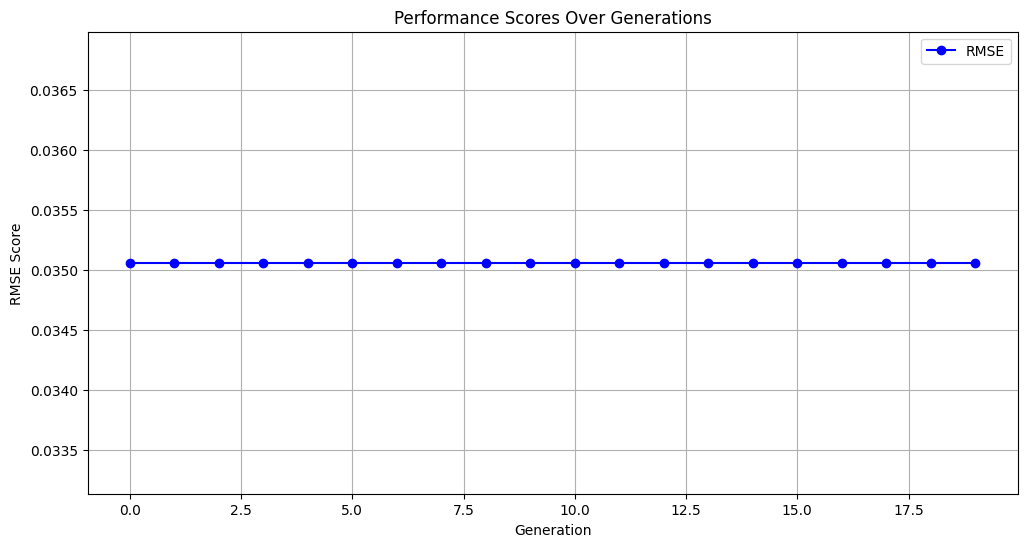

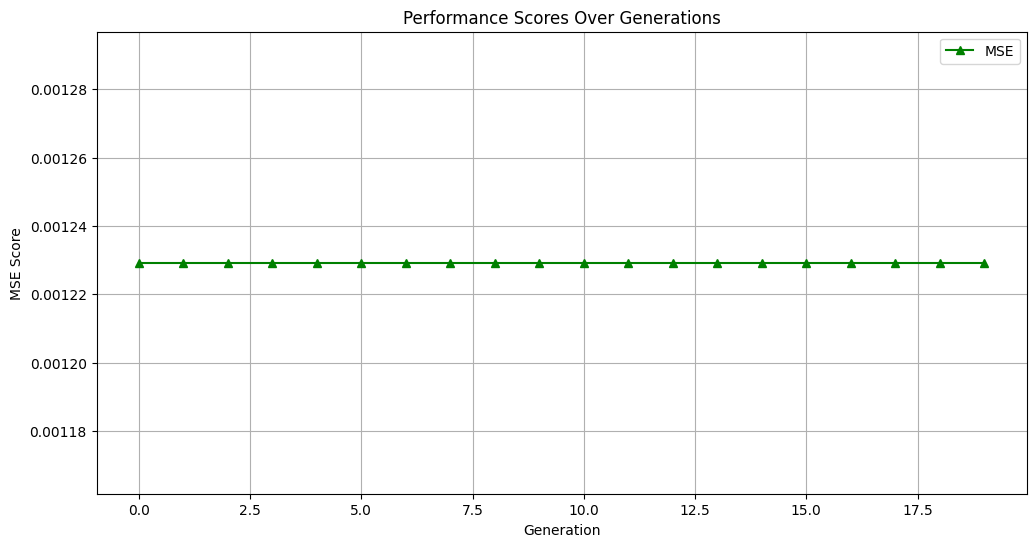

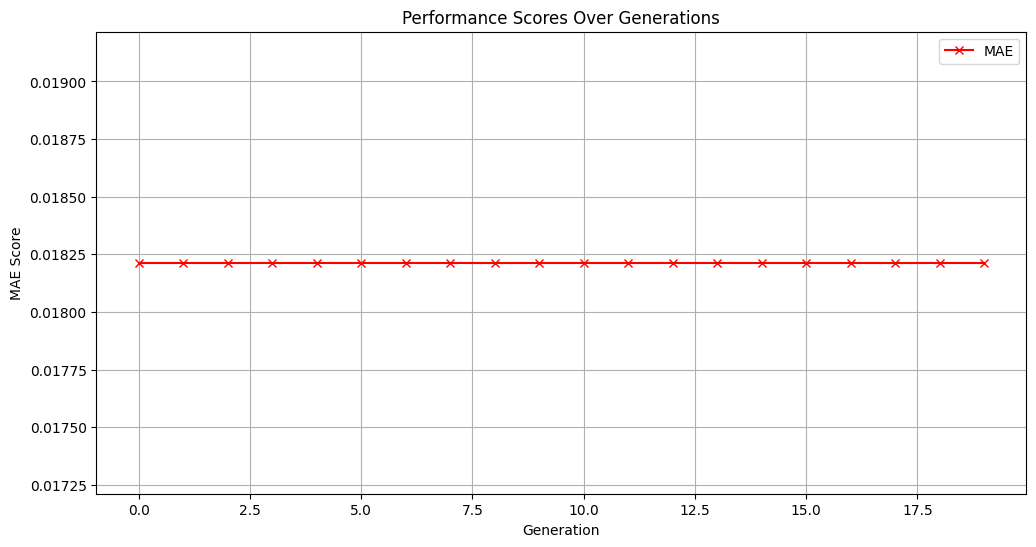

In [116]:
plt.figure(figsize=(12, 6))
plt.plot(rmse_scores_over_generations, marker='o', linestyle='-', color='b', label='RMSE')
#plt.plot(mae_scores_over_generations, marker='x', linestyle='-', color='r', label='MAE')
#plt.plot(mse_scores_over_generations, marker='^', linestyle='-', color='g', label='MSE')
plt.title('Performance Scores Over Generations')
plt.xlabel('Generation')
plt.ylabel('RMSE Score')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
#plt.plot(rmse_scores_over_generations, marker='o', linestyle='-', color='b', label='RMSE')
#plt.plot(mae_scores_over_generations, marker='x', linestyle='-', color='r', label='MAE')
plt.plot(mse_scores_over_generations, marker='^', linestyle='-', color='g', label='MSE')
plt.title('Performance Scores Over Generations')
plt.xlabel('Generation')
plt.ylabel('MSE Score')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
#plt.plot(rmse_scores_over_generations, marker='o', linestyle='-', color='b', label='RMSE')
plt.plot(mae_scores_over_generations, marker='x', linestyle='-', color='r', label='MAE')
#plt.plot(mse_scores_over_generations, marker='^', linestyle='-', color='g', label='MSE')
plt.title('Performance Scores Over Generations')
plt.xlabel('Generation')
plt.ylabel('MAE Score')
plt.legend()
plt.grid(True)
plt.show()

##  Plotting the weight matrices

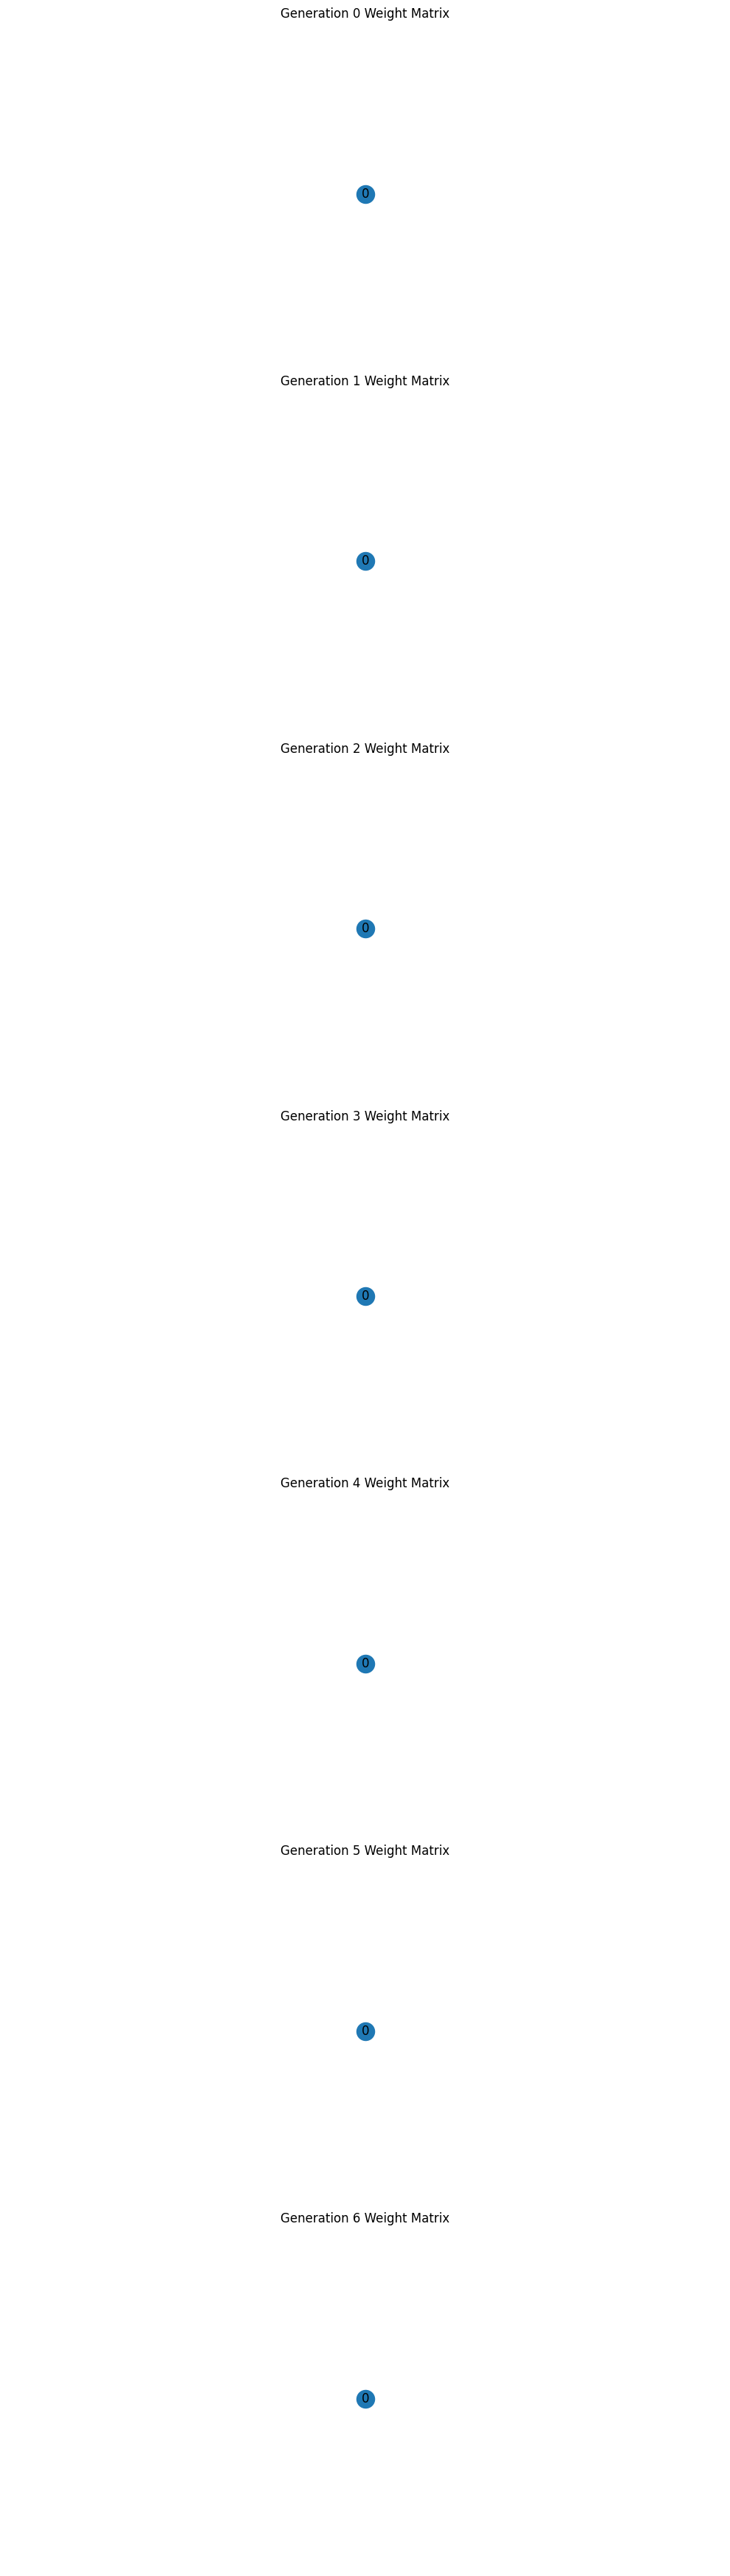

In [130]:
# Now plot the weight matrices
fig, axes = plt.subplots(len(best_weight_matrices), 1, figsize=(10, len(best_weight_matrices)*5))
for i, weight_matrix in enumerate(best_weight_matrices):
    ax = axes[i]
    weight_matrix = np.abs(weight_matrix)
    weight_matrix += weight_matrix != 0

    graph = nx.from_numpy_array(weight_matrix, create_using=nx.DiGraph)
    nx.draw_kamada_kawai(graph, ax=ax, with_labels=True)
    ax.set_title(f"Generation {i} Weight Matrix")

plt.tight_layout()
plt.show()